In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp gaussian_sensor_model

# Gaussian Renderer

In [3]:
#|export
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from functools import partial
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.math import lambertw

normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf
inv = jnp.linalg.inv

key = jax.random.PRNGKey(0)

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [4]:
import traceviz.client
from traceviz.proto import  viz_pb2
import json
import inspect
from IPython.display import Markdown as md
from bayes3d._mkl.plotting import *

In [5]:
#|export
from bayes3d._mkl.types import *

In [6]:
#|export
def ellipsoid_embedding(cov:CovarianceMatrix) -> Matrix:
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ U.T

In [7]:
#|export
def bilinear(x:Array, y:Array, A:Matrix) -> Float:
    return x.T @ A @ y

In [8]:
#|export
def log_gaussian(x:Vector, mu:Vector, P:PrecisionMatrix) -> Float:
    """Evaluate an **unnormalized** gaussian at a given point."""
    return -0.5 * bilinear(x-mu, x-mu, P)


def gaussian(x:Vector, mu:Vector, P:PrecisionMatrix) -> Float:
    """Evaluate an **unnormalized** gaussian at a given point."""
    return jnp.exp(-0.5 * bilinear(x-mu, x-mu, P))


def gaussian_normalizing_constant(P:PrecisionMatrix) -> Float:
    """Returns the normalizing constant of an unnormalized gaussian."""
    n = P.shape[0]
    return jnp.sqrt(jnp.linalg.det(P)/(2*jnp.pi)**n)

In [9]:
#|export
def gaussian_restriction_to_ray(loc:Vector, P:PrecisionMatrix, A:CholeskyMatrix, x:Vector, v:Direction):
    """
    Restricts a gaussian to a ray and returns 
    the mean `mu` and standard deviation `std`, s.t. we have 
    $$
        P(x + t*v | loc, cov) = P(x + mu*v | loc, cov) * N(t | mu, std)
    $$
    """
    mu  = bilinear(loc - x, v, P)/bilinear(v, v, P)
    std = 1/jnp.linalg.norm(inv(A)@v)
    return mu, std

## Time of first arrival

In [10]:
#|export
def discrete_arrival_probabilities(occupancy_probs:Vector):
    """
    Given an vector of `n` occupancy probabilities of neighbouring pixels, 
    it returns a vector of length `n+1` containing the probabilities of stopping 
    at a each pixel (while traversing them left to right) or not stopping at all.

    The return array is given by:
    $$
        q_i = p_i \cdot \prod_{j=0}^{i-1} (1 - p_j)
        
    $$
    for $i=0,...,n-1$, and
    $$
        q_n = \prod_{j=1}^{n-1} (1 - p_j) = 1 - \sum_{i=0}^{n-1} q_i.
    $$

    This is basically the discrete version of time of first arrival $X$ for an imhomogenous poisson processes
    with rate function $\sigma(t)$:
    $$
        X(T) = \sigma(T)*\exp(- \int_0^T \sigma(t) \ dt).
    $$
    """
    transmittances       = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1-occupancy_probs)])
    extended_occupancies = jnp.concatenate([occupancy_probs, jnp.array([1.0])])
    return extended_occupancies * transmittances

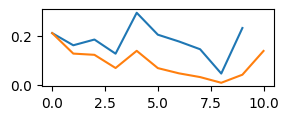

In [11]:
key = keysplit(key)
occupancy_probs = 0.3*jax.random.uniform(key, (10,))
arrival_probs   = discrete_arrival_probabilities(occupancy_probs)

assert jnp.isclose(arrival_probs.sum(), 1.0)

# =======================
plt.figure(figsize=(3,1))
plt.plot(jnp.arange(len(occupancy_probs)), occupancy_probs)
plt.plot(jnp.arange(len(occupancy_probs)+1), arrival_probs);

In [12]:
#|export
def gaussian_time_of_arrival(xs, mu, sig, w=1.0):
    """
    Time of first arrival for a **single** weighted 1-dimensional Gaussian, i.e. returns an array of
    with entries
    $$
        Y(T) = w*g(T | \mu, \sigma)*\exp(- \int_0^T w*g(t | \mu, \sigma) \ dt).
    $$
    """
    ys = w*normal_pdf(xs, loc=mu, scale=sig) * jnp.exp(
            - w*normal_cdf(xs, loc=mu, scale=sig) 
            + w*normal_cdf(0.0, loc=mu, scale=sig))
    return ys 


def gaussian_most_likely_time_of_arrival(mu, sig, w=1.):
    """
    Returns the most likely time of first arrival
    for a single weighted 1-dimensional Gaussian, i.e. the argmax of 
    $$
        Y(T) = w*g(T | \mu, \sigma)*\exp(- \int_0^T w*g(t | \mu, \sigma) \ dt).
    $$
    """
    # TODO: Check if this is correct, cf. my notes.
    Z = jnp.sqrt(lambertw(1/(2*jnp.pi) * w**2))
    return mu - Z*sig


    mu:  7.582
    sig: 0.864
    w:   0.535  
    t:   7.402



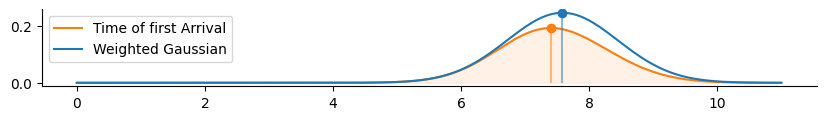

In [13]:
key, keys = keysplit(key,1,3)

xs = jnp.linspace(0,11,20_000)
mu  = jax.random.uniform(keys[0],(), float, 3.0,8.0)
sig = jax.random.uniform(keys[1],(), float, 0.1,2.0)
w   = jax.random.uniform(keys[2],(), float, 0.1,1.0)
t   = gaussian_most_likely_time_of_arrival(mu, sig, w=w)

print(f"""
    mu:  {mu:0.3f}
    sig: {sig:0.3f}
    w:   {w:0.3f}  
    t:   {t:0.3f}
""")

# =======================
plt.figure(figsize=(10,1))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(xs, gaussian_time_of_arrival(xs, mu, sig, w), c="C1", alpha=1., label="Time of first Arrival")
plt.fill_between(xs, gaussian_time_of_arrival(xs, mu, sig, w), color="C1", alpha=0.1)
plt.vlines(t, 0, gaussian_time_of_arrival(t, mu, sig, w), color="C1", alpha=.5)
plt.scatter(t, gaussian_time_of_arrival(t, mu, sig, w), c="C1")
plt.plot(xs, w*normal_pdf(xs, loc=mu, scale=sig), c="C0", alpha=1., label="Weighted Gaussian")
plt.vlines(mu, 0, w*normal_pdf(mu, loc=mu, scale=sig), color="C0", alpha=.5)
plt.scatter(mu, w*normal_pdf(mu, loc=mu, scale=sig), c="C0")
plt.legend();

## Fuzzy Intersections

In [14]:
#|export
def weighted_arrival_intersection(mu:Vector, P:PrecisionMatrix, A:CholeskyMatrix, w:Float, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t0, sig0 = gaussian_restriction_to_ray(mu, P, A, x, v)
    w0 = w*gaussian(t0*v, mu, P)
    Z = w0/gaussian_normalizing_constant(P)
    t = gaussian_most_likely_time_of_arrival(t0, sig0, Z)
    return t, w0

In [15]:
#|export
def weighted_argmax_intersection(mu:Vector, P:PrecisionMatrix, w:Float, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t = bilinear(mu - x, v, P)/bilinear(v, v, P)
    return t, w*gaussian(x + t*v, mu, P)

## Particle arrival probs

In [16]:
THRESH_99 = gaussian(jnp.array([4,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_97 = gaussian(jnp.array([3,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_73 = gaussian(jnp.array([2,0,0]), jnp.zeros(3), jnp.eye(3))

In [17]:
order = jnp.array([2,0,3,1])
jnp.arange(4)[order]
jnp.argsort(order)

Array([1, 3, 0, 2], dtype=int32)

In [18]:
#|export
def _particle_arrival_probs(
        v: "Ray direction", 
        particle_positions, 
        precisions, 
        embeddings, 
        weights): 
    """
    Returns the arrival particles for each particles along a ray 
    (in the order of the particles).
    """
    # TODO: Deal with negative intersections behind the camera
    # TODO: Maybe switch to log probs?

    # Compute fuzzy intersections `xs` with Gaussians and 
    # their function values `sigmas`
    origin = jnp.zeros(3)
    ts, sigmas = vmap(weighted_arrival_intersection, (0,0,0,0,None,None))(
                        particle_positions, precisions, embeddings, weights, origin, v)

    order  = jnp.argsort(ts)
    
    ts     = ts[order]
    sigmas = sigmas[order]
    xs     = ts[:,None]*v[None,:]

    # TODO: Ensure that alphas are in [0,1]
    # TODO: Should we reset the color opacity to `op`?
    # Alternatively we can set `alphas = (1 - jnp.exp(-sigmas*1.0))` -- cf. Fuzzy Metaballs paper
    alphas = sigmas * (ts > 0)
    arrival_probs = discrete_arrival_probabilities(alphas)
    op = 1 - arrival_probs[-1] # Opacity
    inverse_order = jnp.concatenate([jnp.argsort(order), jnp.array([len(order)])])

    return arrival_probs[inverse_order]


particle_arrival_probs = jit(vmap(_particle_arrival_probs, (0,None,None,None,None,)))

In [19]:
w = 100
h = 100
f = 300
intr = Intrinsics(width = w, height = h,fx = f, fy = f,
            cx = w/2 - 0.5, cy = h/2 - 0.5, near = 1e-6, far = 5.0)

cam_pose = transform_from_pos_target_up(.5*jnp.array([.1, 0., 1.5]), jnp.array([0,0.0,0]), jnp.array([0,1,0]))
cam_K    = K_from_intrinsics(intr)
rays     = camera_rays_from_intrinsics(intr)

In [20]:
from sklearn.mixture import GaussianMixture

name = ["banana", "scissors"][1]
num_components = 1000
data = jnp.load(f"data/gaussian_examples/gaussians_{name}_{num_components}.npz")


mus    = data["mus"]
covs   = data["covs"]
cols = data["colors"]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10000, 558)

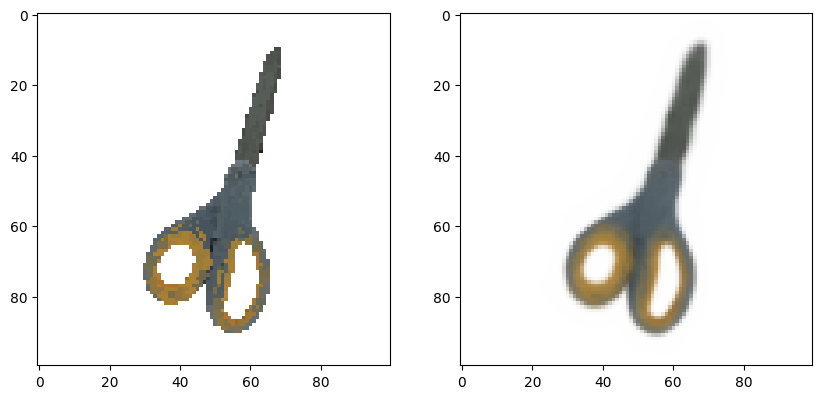

In [55]:
positions  = (mus - cam_pose[:3,3]) @ cam_pose[:3,:3] # same as mapping `mu -> inv(cam_pose) @ mu``
embeddings = 1.5*vmap(lambda cov: cam_pose[:3,:3].T@ellipsoid_embedding(cov))(covs)
covariances = vmap(lambda emb: emb@emb.T)(embeddings)
precisions = vmap(inv)(covariances)
weights    = 0.5*jnp.ones(len(positions))
bg_color  = jnp.array([1.,1.,1.,1.])


colors = jnp.concatenate([cols, bg_color[None]], axis=0)

probs = particle_arrival_probs(
        rays.reshape(-1,3),
        positions, 
        precisions, 
        embeddings, 
        weights)


I = jnp.argmax(probs, axis=-1)

avg  = (probs[:,:,None] * colors[None]).sum(-2)

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(colors[I].reshape(h,w,-1))
axs[1].imshow(avg.reshape(h,w,-1))
probs.shape

In [37]:
from bayes3d._mkl.trimesh_to_gaussians import pack_transform, ellipsoid_embedding
import traceviz.client
import numpy as np
from traceviz.proto import  viz_pb2
import json


transforms = vmap(pack_transform, (0,0,None))(
    positions - positions.mean(axis=0,keepdims=True), 
    embeddings, 
    1.0)


msg = viz_pb2.Message()
msg.pytree.MergeFrom(traceviz.client.to_pytree_msg({"type": "setup",}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

msg = viz_pb2.Message()
msg.pytree.MergeFrom(traceviz.client.to_pytree_msg({
        "type": "gaussians",
        "data": {
            "transforms": np.array(transforms[None]),
            'colors':  np.array(cols[None])
        }
    }))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-12-12T22:09:48.709215 :: ipv4:127.0.0.1:50370"

response:  listener_identifiers: "2023-12-12T22:09:48.709215 :: ipv4:127.0.0.1:50370"



In [38]:
def logit(x):
    return jnp.log(x/(1-x))

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

def fig_to_image(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return img

In [69]:
images = []

avg = jnp.zeros((h,w,4))

for t in range(100):

    key = keysplit(key)
    I = jax.random.categorical(key, logit(probs))
    im = colors[I].reshape(h,w,-1)
    avg += im


    fig, axs = plt.subplots(1,2)
    axs[0].set_title(f"Sample ({t+1}/100)")
    axs[0].imshow(im)

    axs[1].set_title("Sample mean")
    axs[1].imshow(avg/(t+1))

    axs[0].axis("off")
    axs[1].axis("off")
    # Convert figure to image and store
    images.append(fig_to_image(fig))
    plt.close(fig)


In [70]:
import imageio
from IPython.display import Image, display

# Convert PIL Images to NumPy arrays as required by imageio
np_images = [np.array(img) for img in images]

# Save as GIF in memory
gif_io = io.BytesIO()
imageio.mimsave(gif_io, np_images, format='gif', fps=10, loop=1)
gif_io.seek(0)

# Display the GIF in the notebook
# display(Image(data=gif_io.read(), format='png'))

# Save the GIF to disk
gif_filename = f"_outputs/ani_{name}.gif"
with open(gif_filename, 'wb') as f:
    f.write(gif_io.getbuffer())

display(Image(url=gif_filename))